In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from IPython.display import SVG

from sklearn.metrics import r2_score


#from keras.utils.vis_utils import model_to_dot
#from keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


from IPython.display import Image
import glob
import cv2
import random


from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
import tensorflow

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50
# https://blog.roboflow.com/what-is-resnet-50/

input_shape = (128, 128, 3)  # Example input shape for an RGB image
inputs = Input(shape=input_shape)


df = pd.read_csv('df.csv', index_col= 0)

In [4]:
image_rows = 128
image_cols = 128
batch_size = 4096

X   = df.drop(['Age', 'Gender'], axis = 1)
y = df['Gender']
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

y = df['Age']
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X, y, test_size=0.25, random_state=42)



image_shape = (image_rows,image_cols,3)
train_data = np.array(X_train, dtype = 'float32')
test_data = np.array(X_test, dtype='float32')

train_data = train_data.reshape(train_data.shape[0],*image_shape)
test_data = test_data.reshape(test_data.shape[0],*image_shape)

x_train = train_data/255
x_test= test_data/255

In [3]:
# Load Pre-trained ResNet50 Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [5]:
# Create input layer
inputs = Input(shape=(128, 128, 3))

# Pass the inputs through the base model
x = base_model(inputs, training=False)
x = Flatten()(x)

# Classification head for gender classification
classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)

# Regression head for age estimation
regression_output = Dense(1, name='regression_output')(x)

# Create the multi-output model
model = Model(inputs=inputs, outputs=[classification_output, regression_output])

In [6]:
# Compile the model with appropriate loss functions and metrics for both classification and regression
# mae
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'classification_output': 'binary_crossentropy', 'regression_output': 'mae'},
              metrics={'classification_output': 'accuracy', 'regression_output': 'mae'})

In [7]:
history = model.fit(x_train, 
                    {'classification_output': y_class_train, 'regression_output': y_reg_train},
                    epochs=40, batch_size=32, validation_split=0.2)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - classification_output_accuracy: 0.4231 - loss: 2919.5828 - regression_output_mae: 47.0463 - val_classification_output_accuracy: 0.5714 - val_loss: 2602.4011 - val_regression_output_mae: 42.3923
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - classification_output_accuracy: 0.5531 - loss: 1396.8401 - regression_output_mae: 31.6057 - val_classification_output_accuracy: 0.5714 - val_loss: 2517.4856 - val_regression_output_mae: 41.4971
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - classification_output_accuracy: 0.7252 - loss: 445.8445 - regression_output_mae: 16.6287 - val_classification_output_accuracy: 0.4643 - val_loss: 2363.1003 - val_regression_output_mae: 39.8596
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - classification_output_accuracy: 0.7261 - loss: 110.5030 - regression_output_mae: 8.1514 - val_classification_output_accuracy: 0.4643 - val_loss: 2131.3569 - val_regression_output_mae: 37.3597
Epoch 5/40
4/4 ━━━━━━━━━━━━

In [9]:
print(history.history.keys())


dict_keys(['classification_output_accuracy', 'loss', 'regression_output_mae', 'val_classification_output_accuracy', 'val_loss', 'val_regression_output_mae'])


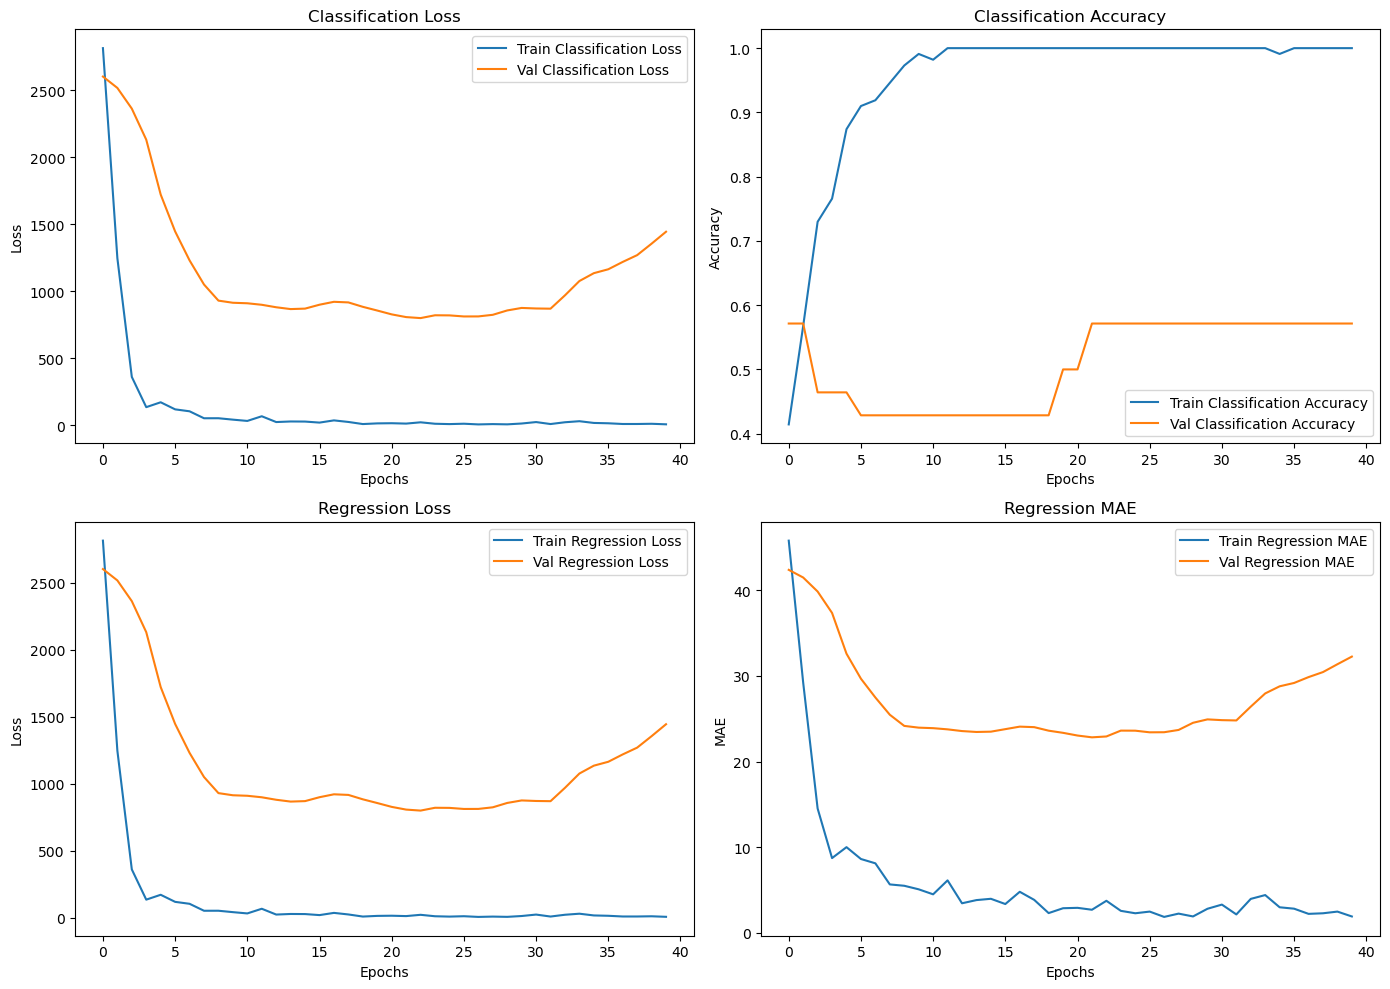

In [10]:
# Create a 2x2 grid for the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot the loss of the gender classification over the training and validation set
axs[0, 0].plot(history.history['loss'], label='Train Classification Loss')
axs[0, 0].plot(history.history['val_loss'], label='Val Classification Loss')
axs[0, 0].set_title('Classification Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# Plot the accuracy of the gender classification over the training and validation set
axs[0, 1].plot(history.history['classification_output_accuracy'], label='Train Classification Accuracy')
axs[0, 1].plot(history.history['val_classification_output_accuracy'], label='Val Classification Accuracy')
axs[0, 1].set_title('Classification Accuracy')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# Plot the loss of the age estimation over the training and validation set
axs[1, 0].plot(history.history['loss'], label='Train Regression Loss')
axs[1, 0].plot(history.history['val_loss'], label='Val Regression Loss')
axs[1, 0].set_title('Regression Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Plot the MAE of the age estimation over the training and validation set
axs[1, 1].plot(history.history['regression_output_mae'], label='Train Regression MAE')
axs[1, 1].plot(history.history['val_regression_output_mae'], label='Val Regression MAE')
axs[1, 1].set_title('Regression MAE')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('MAE')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()
